In [86]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #
import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp
from scipy import constants 


In [87]:

"""Test the electron cooler by comparing the cooling rate and cooling force with Betacool for Leir.
"""
data = np.load('emittance_betacool.npz')
emittance_betacool = data['emittance']
time_betacool = data['time']

beta_rel = 0.09423258405
gamma = 1.004469679
current = 0.6
cooler_length = 3  # m cooler length
radius_e_beam = 25 * 1e-3
temp_perp = 0.01  # <E> [eV] = kb*T
temp_long = 0.001  # <E> [eV]
magnetic_field = 0.07  # T for LEIR
mass0 = 193729.0248722061 * 1e6  # eV/c^2
clight = 299792458.0
p0c = mass0 * beta_rel * gamma  # eV/c
q0 = 54
circumference = 78.54370266  # m
s_per_turn = circumference / (clight * beta_rel)
beta_x = 5
beta_y = 5
Q_x = 1.82
Q_y = 2.72
dQx = -0.0005113579791
dQy = -0.0001665178543

arc = xt.LineSegmentMap(
    qx=Q_x, qy=Q_y, qs=0,
    dqx=dQx, dqy=dQy,
    bets=1 * 1e40, length=circumference,
    betx=beta_x,
    bety=beta_y)

num_particles = 1000  # increase for better convergence
emittance = 14 * 1e-6  # initial emittance
sigma_x = np.sqrt(beta_x * emittance)
sigma_px = np.sqrt(emittance / beta_x)
sigma_y = np.sqrt(beta_y * emittance)
sigma_py = np.sqrt(emittance / beta_y)
sigma_p = 5e-3

delta = np.random.normal(loc=0.0, scale=sigma_p, size=num_particles)
x = np.random.normal(loc=0.0, scale=sigma_x, size=num_particles)
px = np.random.normal(loc=0.0, scale=sigma_px, size=num_particles)
y = np.random.normal(loc=0.0, scale=sigma_y, size=num_particles)
py = np.random.normal(loc=0.0, scale=sigma_py, size=num_particles)

particles = xp.Particles(
    mass0=mass0,
    p0c=p0c,
    q0=q0,
    x=x,
    px=px,
    y=y,
    py=py,
    delta=delta,
    zeta=0)

cooler = xt.ElectronCooler(
    current=current, length=cooler_length, radius_e_beam=radius_e_beam,
    temp_perp=temp_perp, temp_long=temp_long, magnetic_field=magnetic_field, magnetic_field_ratio=0,
    space_charge_factor=0)

num_turns = 34700
emittance_list = []

for i in range(num_turns):
    x_xs = particles.x.copy()
    px_xs = particles.px.copy()
    cov00 = np.cov(x_xs, px_xs)
    det00 = np.sqrt(np.linalg.det(cov00))
    emittance_list.append(det00)
    arc.track(particles)
    cooler.track(particles)
time = np.arange(0, num_turns, 1) * s_per_turn

for i in range(len(time_betacool) - 1, -1, -1):
    if not np.isnan(time_betacool[i]):
        last_non_nan_index = i
        break

time_betacool = time_betacool[:last_non_nan_index]
matched_indices = [np.abs(time - time_value).argmin() for time_value in time_betacool]
emittance_xsuite = [emittance_list[index] for index in matched_indices]
emittance_betacool = emittance_betacool[:last_non_nan_index]
emittance_diff = emittance_xsuite - emittance_betacool
mse_emittance = np.mean(emittance_diff**2)

data_betacool = np.load('force_betacool.npz')
v_diff_betacool = data_betacool['v_diff']
force_betacool = data_betacool['force']
num_particles = int(1e3)

dtk_particle = dtk.TestParticles(
    mass0=mass0,
    p0c=p0c,
    x=np.random.normal(0, 1e-20, num_particles),
    px=np.random.normal(0, 4*np.sqrt(emittance/beta_x), num_particles),
    y=np.random.normal(0, 1e-20, num_particles),
    py=np.random.normal(0, 1e-20, num_particles),
    delta=np.random.normal(0, 0, num_particles),
    zeta=np.random.normal(0, 0, num_particles),
    q0=q0)

dtk_cooler = dtk.elements.ElectronCooler(
    current=current, length=cooler_length, radius_e_beam=radius_e_beam,
    temp_perp=temp_perp, temp_long=temp_long, magnetic_field=magnetic_field, magnetic_field_ratio=0,
    space_charge_factor=0)

force, Fy, Fl = dtk_cooler.force(dtk_particle)

px_tot = p0c*dtk_particle.px
beta_diff = px_tot/(mass0*gamma)
v_diff = beta_diff*clight

sorted_indices = np.argsort(v_diff)
v_diff = v_diff[sorted_indices]
force = force[sorted_indices]
for i in range(len(v_diff_betacool) - 1, -1, -1):
    if not np.isnan(v_diff_betacool[i]):
        last_non_nan_index = i
        break

v_diff_betacool = v_diff_betacool[:last_non_nan_index]

matching_indices = []
for time_value in v_diff_betacool:
    index = np.abs(v_diff - time_value).argmin()
    matching_indices.append(index)

force_xsuite = [force[i] for i in matching_indices]

force_betacool = force_betacool[:last_non_nan_index]

force_diff = force_xsuite - force_betacool
mse_force_transverse = np.mean(force_diff**2)



In [88]:
mse_force_transverse

np.float64(6.215696063994753)

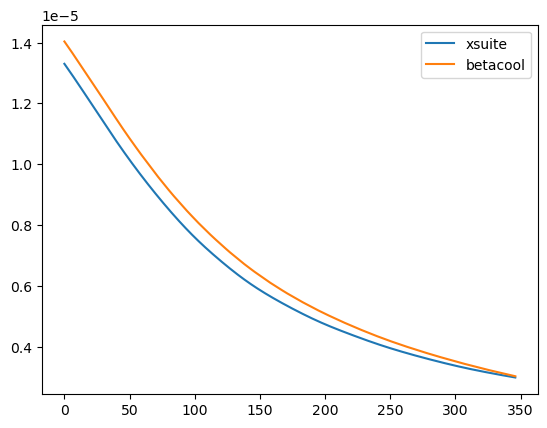

In [89]:
plt.figure()
plt.plot(emittance_xsuite,label='xsuite')
plt.plot(emittance_betacool,label='betacool')
plt.legend()
plt.show()

# plt.figure()

# plt.show()

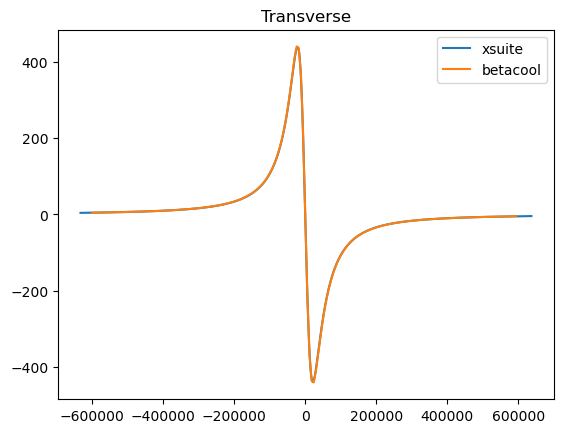

In [90]:
plt.figure()
plt.title('Transverse')
plt.plot(v_diff,force,label='xsuite')
plt.plot(v_diff_betacool,force_betacool,label='betacool')
plt.legend()
plt.show()



In [91]:
num_particles=int(1e5)
gamma0=gamma
beta0=beta_rel
sigma_dp = 1e-2 # from Schotttky
delta=np.linspace(-sigma_dp,sigma_dp,num_particles)
dtk_particle = dtk.TestParticles(
    mass0=mass0,
    gamma0=gamma0,
    p0c=p0c,
    q0=q0,
    x=np.random.normal(0,0 ,num_particles),
    px=np.random.normal(0,0 ,num_particles),
    y=np.random.normal(0, 0 ,num_particles),
    py=np.random.normal(0, 0 ,num_particles),
    delta= delta,
    zeta=np.random.normal(0, 0 ,num_particles),
    )


dtk_cooler = dtk.elements.ElectronCooler(current=current,
                    length=cooler_length,
                    radius_e_beam=radius_e_beam,
                    temp_perp=temp_perp, temp_long=temp_long,
                    magnetic_field=magnetic_field, magnetic_field_ratio=0,
                    space_charge_factor=0,
                    offset_energy=0)

Fx,Fy,force = dtk_cooler.force(dtk_particle)

c=constants.c

##################################################################################################

v_electron_nominal = beta0*c
momentum_diff = delta*p0c
#assume gamma is constant for small momentum deviation
v_diff_longitindal = c*momentum_diff/(mass0*gamma0)

# ##################################################################################################
# px_tot = p0c*dtk_particle.px
# beta_diff = px_tot/(mass0*gamma)
# v_diff = beta_diff*c
# Sort v_diff and force in ascending order
sort_indices = np.argsort(v_diff_longitindal)
v_diff_longitindal = v_diff_longitindal[sort_indices]
force_longitudinal = force[sort_indices]



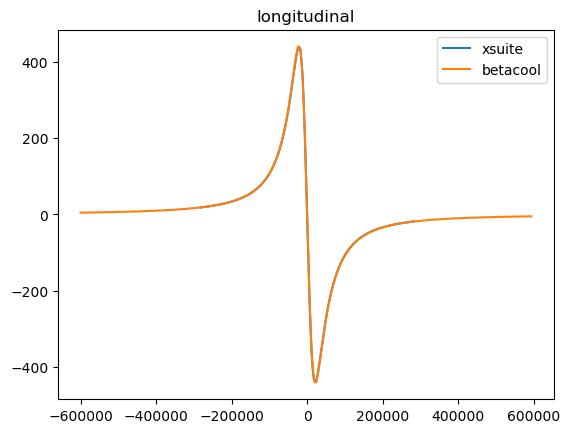

In [92]:
plt.figure()
plt.title('longitudinal')
plt.plot(v_diff_longitindal,force_longitudinal,label='xsuite')
plt.plot(v_diff_betacool,force_betacool,label='betacool')
# plt.xlim([0,200000])
plt.legend()
plt.show()

In [93]:
matching_indices = []
for time_value in v_diff_betacool:
    index = np.abs(v_diff_longitindal - time_value).argmin()
    matching_indices.append(index)

force_longitudinal = [force_longitudinal[i] for i in matching_indices]


force_diff_longitudinal = force_longitudinal - force_betacool
mse_force_longitudinal = np.mean(force_diff_longitudinal**2)

In [94]:
mse_force_longitudinal

np.float64(52.12792113673268)